# Transfer Learning with MobileNetV2

**Project** : Binary classifier (alpaca/ not alpaca) using transfer learning on a pre-trained CNN

**Pretrained model**: MobileNetV2 pre-trained on ImageNet 

**ImageNet**: a dataset containing over 14 million images and 1000 classes

In [1]:
# to suppress TF warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Create dataset from directory and split dataset

When splitting, specify the subset for each portion using `subset='training'` and `subset='validation'`.

Note: Use same random seeds to avoid overlapping between training and validation datasets when shuffling and splitting.

In [2]:
BATCH_SIZE = 32
# IMG_SIZE must be provided since images must all have the same size
# Images will be resized to this size
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2, # 20% test, 80% training
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


### Check a sample of images

**Note:** The original dataset has some mislabelled images in it as well.

Data class names: ['alpaca', 'not alpaca']


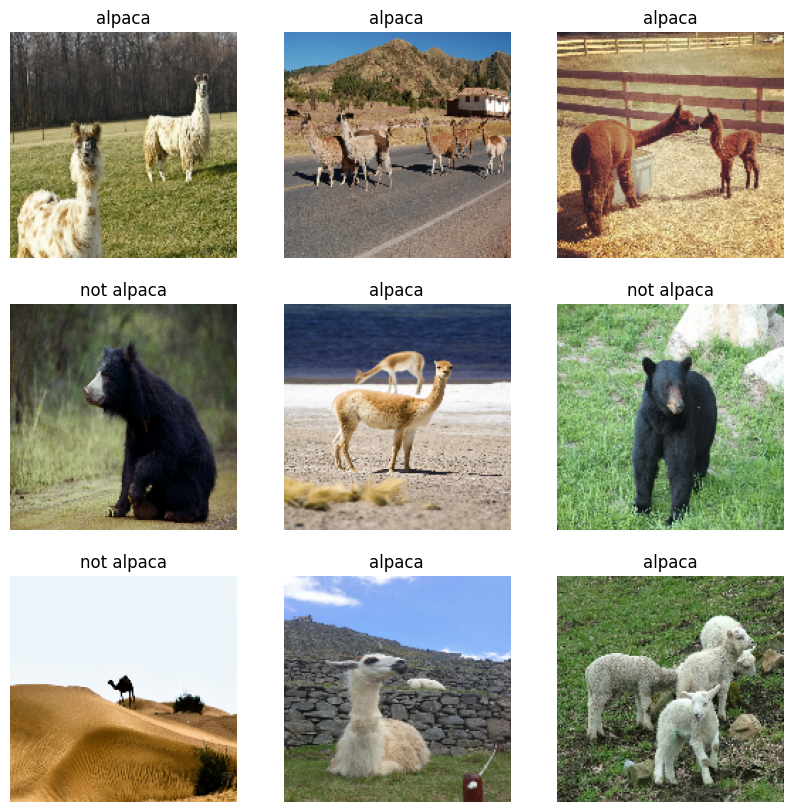

In [3]:
class_names = train_dataset.class_names
print("Data class names:", class_names)
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1): # Take one batch (32 images in this case) 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Preprocess and Augment Training Data

Using `prefetch()` creates the next batch of data and allows preprcessing to be executed while the current batch of data is processing in the model.

This is especially powerful when prcessing is taking place on a GPU, while the CPU can take care of reading and preparing the next batch of data so it can immediately proceed to the processing pipeline without delay.

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

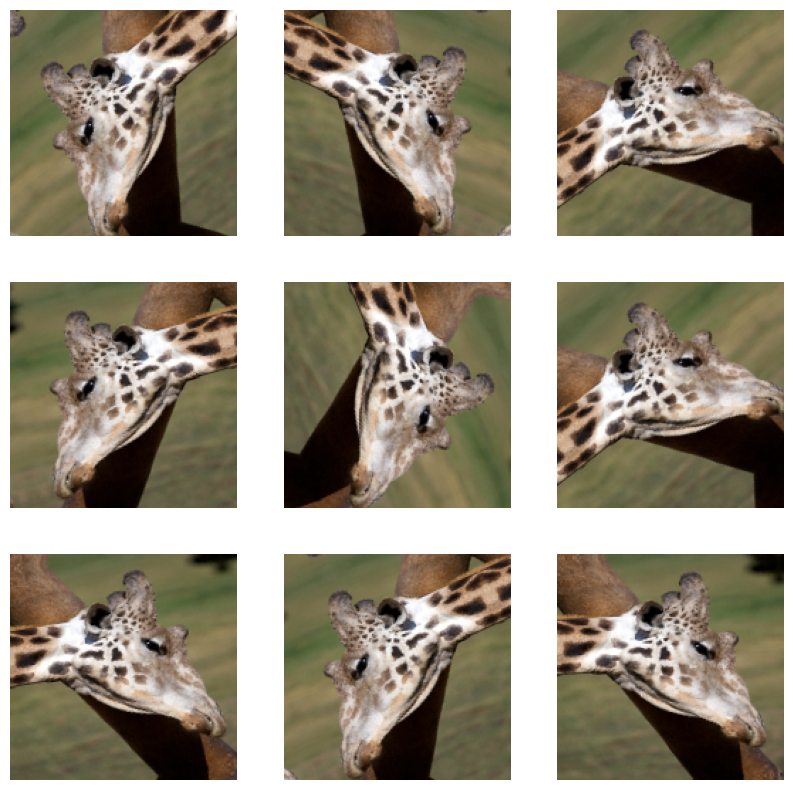

In [6]:
tf.get_logger().setLevel('ERROR') # suppress warnings

# Example augmented image

# Build augmentation model
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
        
# Reuse the normalization values the model was trained on (since it's a pretrained model)
# Grab the whole preprocessing "unit" of this mobilenet application
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2 for Transfer Learning 

MobileNetV2 pre-trained on ImageNet is very efficient for object detection and image segmentation tasks, as well as classification tasks. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<a name='3-1'></a>
### Depthwise separable convolutions and Pointwise convolutions

- In normal convolution, spatial direction and channel direction convolution is done in one step.
- By separating that to two steps instead, the number of parameters can be reduced
  - First Depthwise convolution(spatial): conv done on each channel separately so output channel count equals input channel count
  - Then Point wise (channel direction with 1x1 filters): channels are flattened
- [Nice reference here](https://qiita.com/omiita/items/77dadd5a7b16a104df83)

In [7]:
# Try to train the base model as is
# Since this is a pretrained model, reuse the pretrained weights

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet') # Reuse the pretrained weights

# Model summary
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [8]:
# Last two layers are called top layers, and are responsible for the classification in the model
print(base_model.layers[-2].name)
print(base_model.layers[-1].name)

global_average_pooling2d
predictions


In [9]:
# Test some predictions using the first batch
# labels are 0s or 1s depending on whether image is an alpaca or not
image_batch, label_batch = next(iter(train_dataset))

print("imag_batch shape:", image_batch.shape, "\nlabel_batch shape:", label_batch.shape)

base_model.trainable = False

# Preprocess images using same normalization that was used in pretrained model
image_var = tf.Variable(preprocess_input(image_batch))

# Get predictions: probability of images belonging to each of 1000 classes 
pred = base_model(image_var)
print("predicitons shape:", pred.shape)

# return top 2 label probabilities for each image
tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

# Format
# class number, human-readable label, probability of image belonging to that label/class

# This MobileNet trained on ImageNet doesn't have Alpaca classes
# --> Need to delete the top layer, which contains all the classification labels, 
# and create a new classification layer.

imag_batch shape: (32, 160, 160, 3) 
label_batch shape: (32,)
predicitons shape: (32, 1000)


[[('n02489166', 'proboscis_monkey', 0.1032996),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883582)],
 [('n02125311', 'cougar', 0.16546686), ('n02389026', 'sorrel', 0.107643776)],
 [('n02437312', 'Arabian_camel', 0.29232794),
  ('n02437616', 'llama', 0.27713475)],
 [('n03944341', 'pinwheel', 0.31154975), ('n03047690', 'clog', 0.05250017)],
 [('n02454379', 'armadillo', 0.73107237), ('n01990800', 'isopod', 0.03871969)],
 [('n02437312', 'Arabian_camel', 0.256636),
  ('n02422106', 'hartebeest', 0.12122747)],
 [('n02437616', 'llama', 0.6612561),
  ('n02090721', 'Irish_wolfhound', 0.23782821)],
 [('n02133161', 'American_black_bear', 0.8273564),
  ('n02134418', 'sloth_bear', 0.029259522)],
 [('n01518878', 'ostrich', 0.92675585),
  ('n02002724', 'black_stork', 0.0017766427)],
 [('n01518878', 'ostrich', 0.9495457), ('n02018795', 'bustard', 0.002866152)],
 [('n02437616', 'llama', 0.86998373), ('n02412080', 'ram', 0.07675709)],
 [('n02415577', 'bighorn', 0.24294475), ('n02412080', 'ram', 0.1605

### Layer Freezing with the Functional API

To make this pretrained model recognize alpacas : 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [10]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(units=1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [11]:
# Create new model using the data_augmentation function defined earlier.
model2 = alpaca_model(IMG_SIZE, data_augmentation)

# Check model summary 
model2.summary()

base_learning_rate = 0.001

# Compile model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [12]:
# Fit (train) the model
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 26s 1s/step - loss: 0.7796 - accuracy: 0.5153 - val_loss: 0.5868 - val_accuracy: 0.6308
Epoch 2/5
9/9 [==============================] - 8s 834ms/step - loss: 0.6015 - accuracy: 0.6336 - val_loss: 0.4846 - val_accuracy: 0.7077
Epoch 3/5
9/9 [==============================] - 8s 673ms/step - loss: 0.5007 - accuracy: 0.7252 - val_loss: 0.4259 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 7s 707ms/step - loss: 0.4509 - accuracy: 0.7137 - val_loss: 0.4074 - val_accuracy: 0.7231
Epoch 5/5
9/9 [==============================] - 7s 635ms/step - loss: 0.4133 - accuracy: 0.7595 - val_loss: 0.3372 - val_accuracy: 0.8000


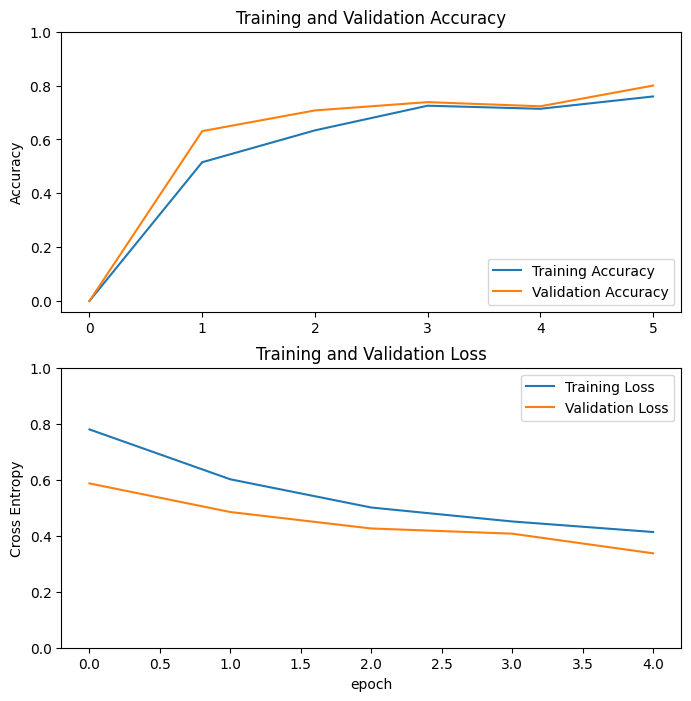

In [13]:
# Plot training and validation errors
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning the Model

In transfer learning, this is achieved by
1) Unfreezing the final layers at the end of the network
2) Re-training the model on the final layers with a very low learning rate to improve accuracy

Intuition: Earlier stages correspond to low-level features, like edges. Later layers correspond to more complex, high-level features like wispy hair or pointy ears - which are what we want to optimize for.

Final layers: Where these begin is a bit arbitrary. One can test around with this.

In [14]:
# grab the mobilenet (base_model) layer and set it all to trainable temporarily
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

# Compile model with unfrozen final layers and lower learning rate
model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

# Fit (train) new model
history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Number of layers in the base model:  154
Epoch 5/10
9/9 [==============================] - 28s 1s/step - loss: 0.4575 - accuracy: 0.7977 - val_loss: 0.3380 - val_accuracy: 0.8154
Epoch 6/10
9/9 [==============================] - 10s 845ms/step - loss: 0.2903 - accuracy: 0.8550 - val_loss: 0.1917 - val_accuracy: 0.8923
Epoch 7/10
9/9 [==============================] - 10s 976ms/step - loss: 0.2301 - accuracy: 0.9008 - val_loss: 0.2845 - val_accuracy: 0.8462
Epoch 8/10
9/9 [==============================] - 8s 793ms/step - loss: 0.2071 - accuracy: 0.9122 - val_loss: 0.1210 - val_accuracy: 0.9077
Epoch 9/10
9/9 [==============================] - 9s 863ms/step - loss: 0.1423 - accuracy: 0.9427 - val_loss: 0.0937 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 9s 858ms/step - loss: 0.0895 - accuracy: 0.9733 - val_loss: 0.0478 - val_accuracy: 1.0000


In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

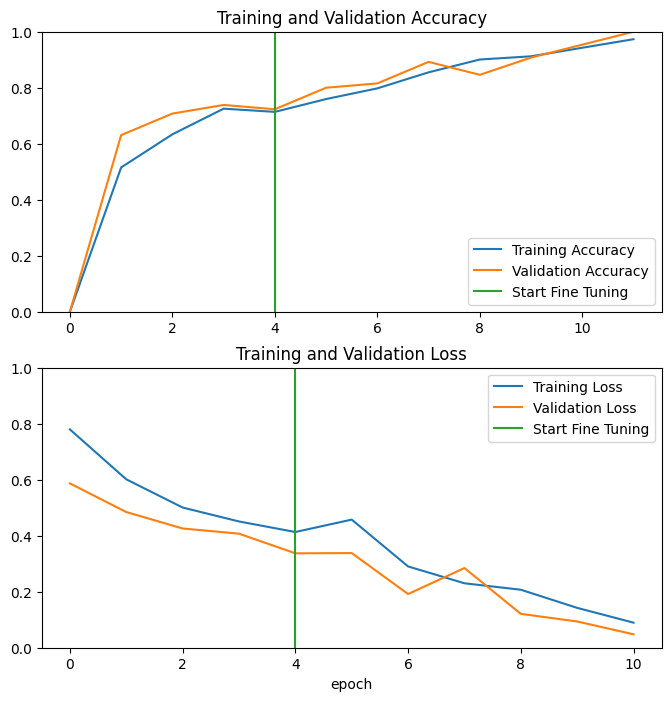

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()